# Climate model evaluation - bias

Absolute:
$$
z_{bias} = \frac{1}{25} \displaystyle\sum_{y=1}^{25}
(\bar{x}_y - \bar{x}_{y_{obs}})
$$

Relative:
$$
z_{bias} = \frac{1}{25} \displaystyle\sum_{y=1}^{25}
\left(\left(\bar{x}_y - \bar{x}_{y_{obs}}\right) \times 100\right)\ (\%)
$$

In [1]:
import importlib
import matplotlib.pyplot as plt
import climag.climag as cplt
import seaborn as sns
import xarray as xr
import geopandas as gpd
import os
import numpy as np

In [2]:
# mask for offshore areas
ie_bbox = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries_all.gpkg"),
    layer="ne_10m_land_2157_IE_BBOX_DIFF",
)
# mask for non-pasture areas
mask = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries_all.gpkg"),
    layer="CLC_2018_MASK_PASTURE_2157_IE",
)

In [46]:
def plot_bias(dataset, label, levels=14):
    fig = dataset.plot.contourf(
        x="x",
        y="y",
        col="model",
        row="dataset_name",
        robust=True,
        extend="both",
        subplot_kws={"projection": cplt.projection_hiresireland},
        transform=cplt.projection_lambert_conformal,
        levels=levels,
        xlim=(-1.775, 1.6),
        ylim=(-2.1, 2.1),
        cbar_kwargs={"location": "bottom", "aspect": 32.5, "pad": 0.05, "shrink": 0.85},
        figsize=(12, 5),
        cmap="RdBu",
        center=0,
    )
    fig.set_titles("{value}", weight="semibold", fontsize=18)
    for axis in fig.axs.flat:
        mask.to_crs(cplt.projection_hiresireland).plot(
            ax=axis, color="white", linewidth=0
        )
        ie_bbox.to_crs(cplt.projection_hiresireland).plot(
            ax=axis,
            edgecolor="darkslategrey",
            color="white",
            linewidth=0.5,
        )
    # custom colorbar font size
    # https://github.com/pydata/xarray/issues/3275
    # https://stackoverflow.com/a/70708167
    fig.cbar.ax.tick_params(labelsize=17)
    fig.cbar.set_label(label=label, size=18)
    plt.show()

In [45]:
def ensemble_mean_bias(dataset, dataset_name):
    bias_mean = dataset.mean(dim="year", skipna=True)
    ds_ens = (
        bias_mean.mean(dim="model", skipna=True)
        .assign_coords(model="Ensemble")
        .expand_dims(dim="model")
    )
    bias_mean_ens = xr.merge([bias_mean, ds_ens])
    # sort models
    bias_mean_ens = bias_mean_ens.reindex(model=cplt.model_list + ["Ensemble"])
    # add dataset name
    bias_mean_ens = bias_mean_ens.assign_coords(dataset_name=dataset_name).expand_dims(dim="dataset_name")
    return bias_mean_ens

In [62]:
def describe_dataset(dataset, model=False):
    dataset_df = dataset.to_dataframe()
    dataset_df = dataset_df.reset_index()[list(dataset.data_vars) + ["model"]]
    dataset_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # dataset_df.dropna(subset=list(dataset.data_vars), inplace=True)
    dataset_df.dropna(subset=list(dataset.data_vars), how="all", inplace=True)
    if model:
        return dataset_df.groupby("model").describe().T
    else:
        return dataset_df.describe()

In [6]:
mera = cplt.load_obs_data()

/mnt/Backup/Documents/Git/ClimAg/ClimAg/.venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(
<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [17]:
importlib.reload(cplt)

<module 'climag.climag' from '/mnt/Backup/Documents/Git/ClimAg/ClimAg/climag/climag.py'>

## EURO-CORDEX

In [7]:
ds_ec = cplt.load_all_data("EURO-CORDEX", hist_only=True)

In [8]:
ds_ec_ann, mera_ann = cplt.regrid_climate_model_data(mera, ds_ec, skipna=True)

In [9]:
bias_abs_ec, bias_rel_ec = cplt.calc_bias(mera_ann, ds_ec_ann)

In [48]:
bias_abs_ec_mean_ens = ensemble_mean_bias(bias_abs_ec, "EURO-CORDEX")
bias_rel_ec_mean_ens = ensemble_mean_bias(bias_rel_ec, "EURO-CORDEX")

In [63]:
describe_dataset(bias_abs_ec_mean_ens)

bm           gro          bm_c
count  72410.000000  72410.000000  72410.000000
mean     614.054932     12.845088    206.791382
std      391.103302      8.900772    316.379150
min    -1529.872681    -26.985115  -1523.248291
25%      361.410385      7.318273     41.429393
50%      556.390900     11.410444    177.698845
75%      808.424484     16.615748    323.439110
max     3683.514160     81.290451   2627.014648

In [64]:
describe_dataset(bias_abs_ec_mean_ens, model=True)

model           CNRM-CM5      EC-EARTH      Ensemble    HadGEM2-ES  \
bm   count  14482.000000  14482.000000  14482.000000  14482.000000   
     mean     575.142151    734.945312    614.054871    485.078705   
     std      385.336670    394.149200    379.986206    367.404022   
     min    -1356.387085  -1238.115356  -1329.043579  -1529.872681   
     25%      326.688904    476.956665    371.775398    250.748096   
     50%      511.845963    676.640015    553.352753    424.787384   
     75%      763.993607    935.291779    797.471283    660.362183   
     max     3477.870605   3683.514160   3511.134766   3331.778320   
gro  count  14482.000000  14482.000000  14482.000000  14482.000000   
     mean       9.208874     13.337394     12.845088     13.221117   
     std        8.173135      8.613291      8.579929      8.839910   
     min      -26.985115    -23.574760    -24.059832    -26.698645   
     25%        4.445365      8.118531      7.658263      7.577592   
     50%        7.894661     11.847657     11.350310     11.749211   
     75%       12.174712     16.799187     16.281956     17.086391   
     max       68.759598     75.488213     76.085640     78.804306   
bm_c count  14482.000000  14482.000000  14482.000000  14482.000000   
     mean      52.736309    194.760147    206.791397    260.677521   
     std      299.905609    301.939392    301.372803    302.763245   
     min    -1523.248291  -1392.323853  -1386.419800  -1340.848389   
     25%      -95.660963     47.502092     58.683504    107.592546   
     50%       26.339301    163.100975    176.363411    233.444313   
     75%      145.388653    288.001625    302.437057    366.981880   
     max     2085.288818   2368.236328   2374.447510   2497.250488   

model         MPI-ESM-LR  
bm   count  14482.000000  
     mean     661.053467  
     std      382.966370  
     min    -1191.799316  
     25%      422.001617  
     50%      607.022034  
     75%      837.185410  
     max     3551.375977  
gro  count  14482.000000  
     mean      15.612970  
     std        9.062233  
     min      -20.435755  
     25%       10.048522  
     50%       14.110590  
     75%       19.231571  
     max       81.290451  
bm_c count  14482.000000  
     mean     318.991638  
     std      312.300323  
     min    -1289.258179  
     25%      158.597557  
     50%      287.242172  
     75%      423.948334  
     max     2627.014648

In [65]:
describe_dataset(bias_rel_ec_mean_ens)

bm           gro          bm_c
count  69940.000000  69940.000000  69615.000000
mean      63.690720     49.825848     32.314201
std       44.919037     43.133617    142.293365
min      -59.662601    -51.684669    -61.340694
25%       38.554394     29.110231      5.365244
50%       58.716999     43.804434     17.269539
75%       80.775753     60.701813     31.931484
max      774.776855    778.505493   6505.246094

In [66]:
describe_dataset(bias_rel_ec_mean_ens, model=True)

model           CNRM-CM5      EC-EARTH      Ensemble    HadGEM2-ES  \
bm   count  13988.000000  13988.000000  13988.000000  13988.000000   
     mean      59.628399     76.094223     63.690712     49.752010   
     std       43.105377     46.640839     43.741383     40.021637   
     min      -52.251221    -49.379063    -52.599503    -59.662601   
     25%       35.549011     50.949010     40.215712     27.988113   
     50%       54.858553     71.305050     59.003929     44.801872   
     75%       76.454618     93.426760     79.718689     64.217152   
     max      717.778748    774.776855    734.779663    692.604919   
gro  count  13988.000000  13988.000000  13988.000000  13988.000000   
     mean      36.879456     51.870117     49.825848     50.133377   
     std       38.978207     43.049587     42.209774     41.545464   
     min      -50.265556    -43.503849    -46.394360    -51.684669   
     25%       18.651882     32.130525     30.221579     30.052701   
     50%       31.464960     45.784527     43.722452     44.149925   
     75%       46.038264     61.637524     59.416100     60.805367   
     max      647.108582    714.718445    714.610474    738.308777   
bm_c count  13923.000000  13923.000000  13923.000000  13923.000000   
     mean      17.967857     31.653290     32.314201     36.892338   
     std      127.245964    143.933640    141.635422    139.764160   
     min      -61.340694    -56.131905    -56.862175    -57.699478   
     25%       -4.897099      5.741924      6.713305     10.662113   
     50%        4.273828     15.967339     16.958004     21.529671   
     75%       16.020338     29.514111     30.261938     35.710617   
     max     5116.378906   6063.274902   5679.642090   5033.667480   

model         MPI-ESM-LR  
bm   count  13988.000000  
     mean      69.288246  
     std       46.310883  
     min      -49.351246  
     25%       44.737976  
     50%       64.280281  
     75%       85.659979  
     max      753.957947  
gro  count  13988.000000  
     mean      60.420441  
     std       46.245750  
     min      -41.559551  
     25%       39.179217  
     50%       54.054834  
     75%       70.767485  
     max      778.505493  
bm_c count  13923.000000  
     mean      42.743320  
     std      156.217056  
     min      -52.942295  
     25%       15.058560  
     50%       26.107384  
     75%       40.462646  
     max     6505.246094

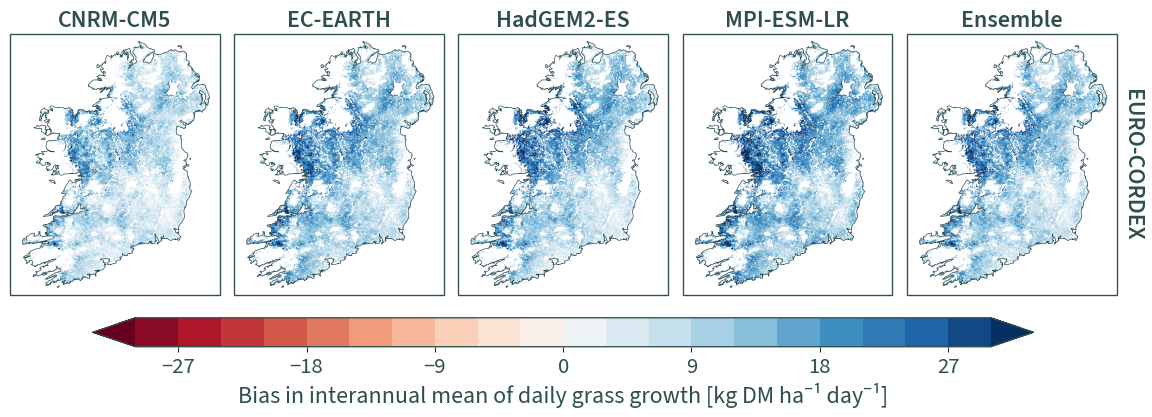

In [49]:
plot_bias(bias_abs_ec_mean_ens["gro"], label="Bias in interannual mean of daily grass growth [kg DM ha⁻¹ day⁻¹]", levels=np.arange(-30, 30 + 3, 3))

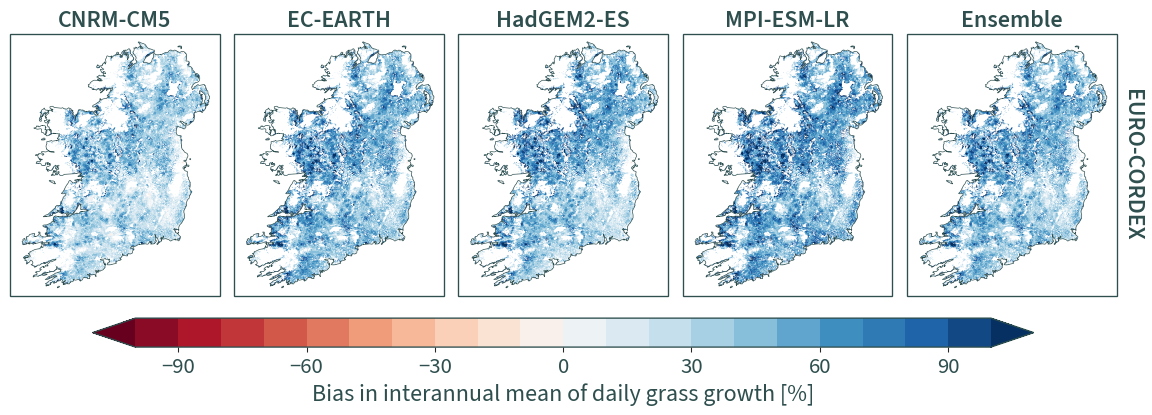

In [54]:
plot_bias(bias_rel_ec_mean_ens["gro"], label="Bias in interannual mean of daily grass growth [%]", levels=np.arange(-100, 100 + 10, 10))

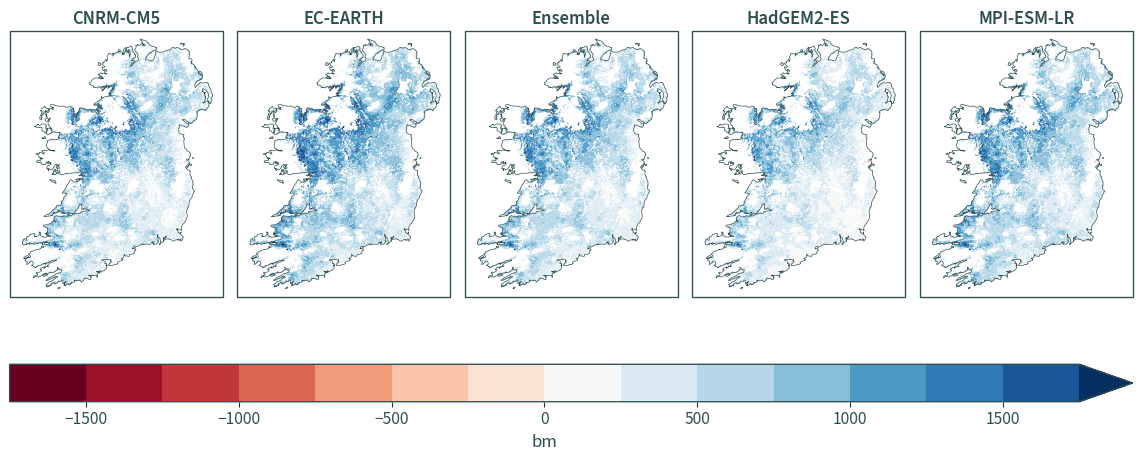

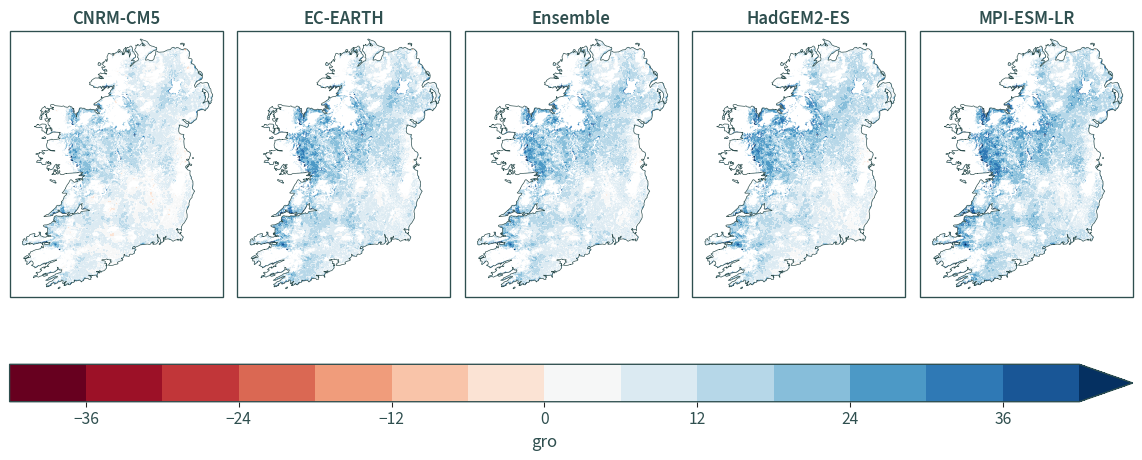

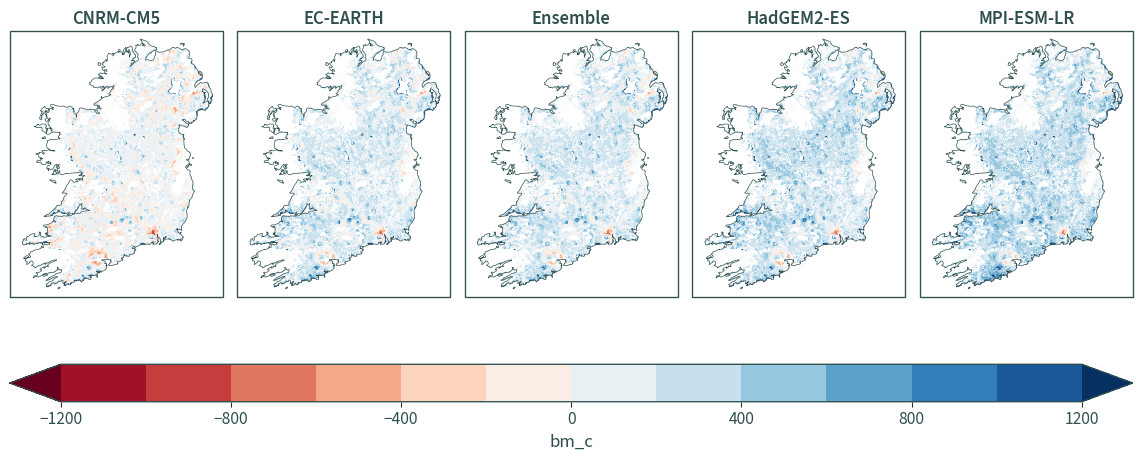

In [54]:
for v in bias_abs_ec_mean_ens.data_vars:
    plot_bias(bias_abs_ec_mean_ens, v)

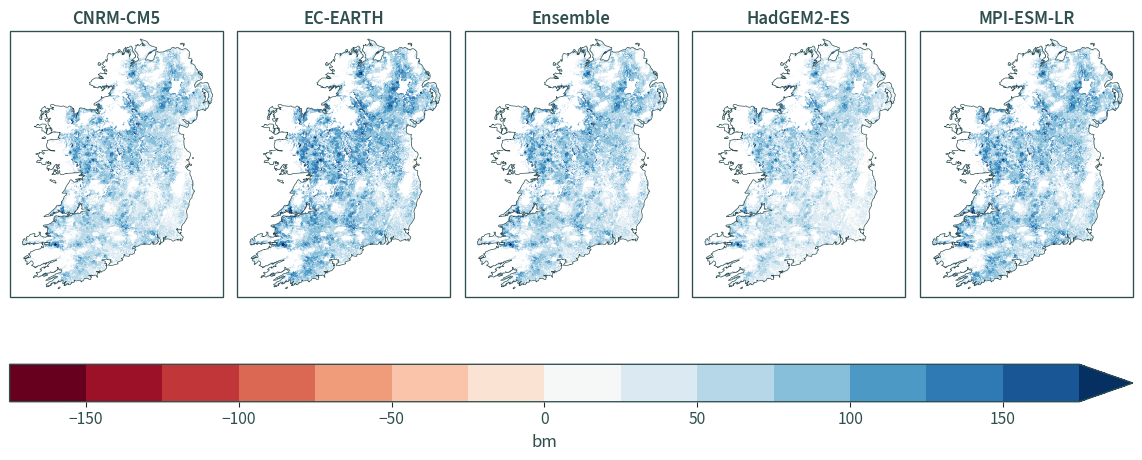

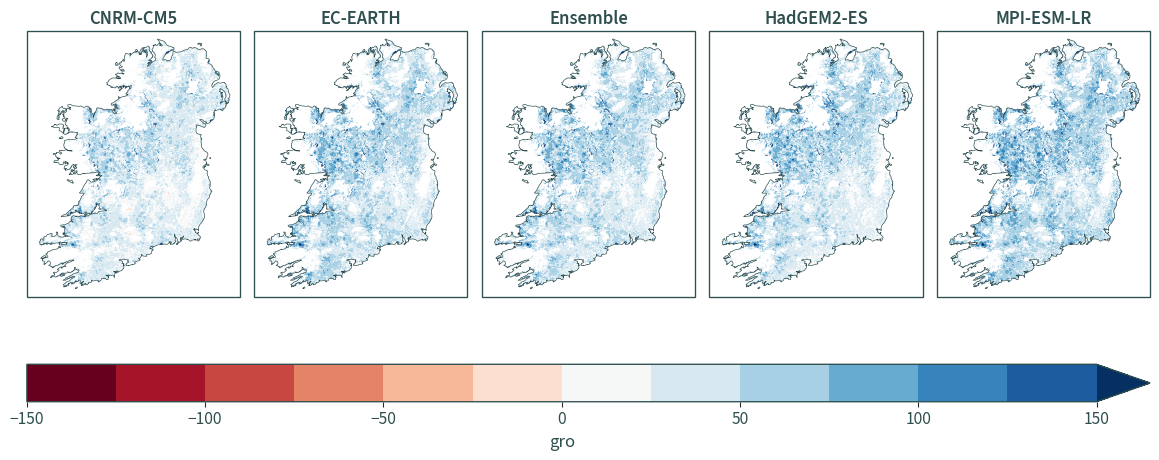

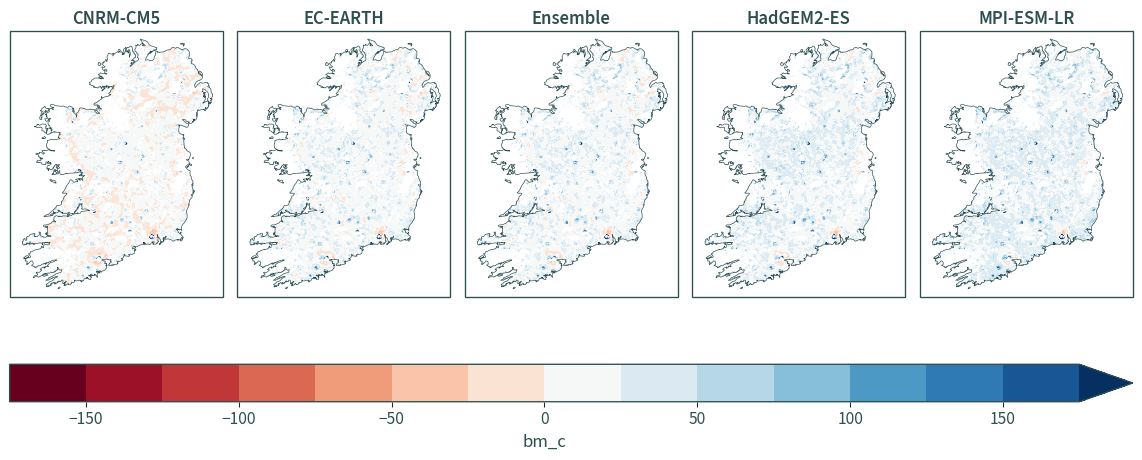

In [55]:
for v in bias_rel_ec_mean_ens.data_vars:
    plot_bias(bias_rel_ec_mean_ens, v)

## HiResIreland

In [23]:
ds_hr = cplt.load_all_data("HiResIreland", hist_only=True)

In [24]:
ds_hr_ann, mera_ann = cplt.regrid_climate_model_data(mera, ds_hr, skipna=True)

In [25]:
bias_abs_hr, bias_rel_hr = cplt.calc_bias(mera_ann, ds_hr_ann)

In [55]:
bias_abs_hr_mean_ens = ensemble_mean_bias(bias_abs_hr, "HiResIreland")
bias_rel_hr_mean_ens = ensemble_mean_bias(bias_rel_hr, "HiResIreland")

In [67]:
describe_dataset(bias_abs_hr_mean_ens)

bm           gro          bm_c
count  69580.000000  69580.000000  69580.000000
mean      23.727112     -1.762646    -64.309181
std      196.741776      4.733763    198.919891
min    -1700.981689    -24.815830  -1472.723145
25%      -82.507298     -4.206002   -164.595921
50%       11.453336     -2.034011    -58.928120
75%      110.936110      0.174663     23.962612
max     2247.223389     56.678280   2869.206543

In [68]:
describe_dataset(bias_abs_hr_mean_ens, model=True)

model           CNRM-CM5      EC-EARTH      Ensemble    HadGEM2-ES  \
bm   count  13916.000000  13916.000000  13916.000000  13916.000000   
     mean      45.859173    130.344833     23.727116    -92.420586   
     std      181.867844    181.070740    176.808578    193.354034   
     min    -1410.330933  -1380.919800  -1450.426270  -1700.981689   
     25%      -48.574262     31.813281    -63.528148   -191.381546   
     50%       26.400825    108.940086      7.742659   -105.853127   
     75%      115.445587    205.217518     88.167917    -16.121259   
     max     1996.662476   2134.263184   2041.794189   1789.027222   
gro  count  13916.000000  13916.000000  13916.000000  13916.000000   
     mean      -3.043556     -0.333233     -1.762646     -2.949077   
     std        4.540734      4.367754      4.451426      4.763321   
     min      -23.904194    -22.240870    -22.414011    -24.815830   
     25%       -5.155138     -2.409428     -3.881019     -5.455038   
     50%       -3.249167     -0.577566     -2.042595     -3.305275   
     75%       -1.348855      1.236817     -0.200343     -1.045165   
     max       46.834549     50.456226     50.090698     46.393734   
bm_c count  13916.000000  13916.000000  13916.000000  13916.000000   
     mean    -154.306717    -20.757917    -64.309189   -104.771049   
     std      195.217834    179.139359    183.871292    197.185501   
     min    -1472.723145  -1406.881348  -1412.200562  -1424.504517   
     25%     -253.492172   -100.053762   -150.491623   -212.047550   
     50%     -154.760933    -21.848114    -63.914415    -97.271278   
     75%      -66.345816     44.576760      6.504643     -4.571097   
     max     2267.465576   2429.714355   2453.536133   2247.759033   

model         MPI-ESM-LR  
bm   count  13916.000000  
     mean      11.125052  
     std      183.112198  
     min    -1309.472778  
     25%      -83.035507  
     50%       -2.315520  
     75%       82.368090  
     max     2247.223389  
gro  count  13916.000000  
     mean      -0.724718  
     std        4.866183  
     min      -21.951555  
     25%       -3.256580  
     50%       -1.075349  
     75%        1.178347  
     max       56.678280  
bm_c count  13916.000000  
     mean      22.598928  
     std      189.149307  
     min    -1344.693481  
     25%      -58.195063  
     50%       14.800886  
     75%       88.366493  
     max     2869.206543

In [69]:
describe_dataset(bias_rel_hr_mean_ens)

bm           gro          bm_c
count  68285.000000  68245.000000  67940.000000
mean       5.684483     -2.406002      0.291001
std       18.680485     17.707634     44.263958
min     -100.000000    -70.847633    -91.660461
25%       -4.828407    -11.309063    -10.350763
50%        4.494545     -4.224236     -3.120318
75%       14.084369      3.640985      4.463100
max      283.228699    322.512390   1708.797852

In [70]:
describe_dataset(bias_rel_hr_mean_ens, model=True)

model           CNRM-CM5      EC-EARTH      Ensemble    HadGEM2-ES  \
bm   count  13657.000000  13657.000000  13657.000000  13657.000000   
     mean       7.542371     16.051826      5.684483     -5.853732   
     std       17.313253     18.062199     16.779415     15.974504   
     min     -100.000000   -100.000000   -100.000000   -100.000000   
     25%       -1.618170      6.929008     -2.776006    -14.732052   
     50%        6.008275     14.646977      4.222023     -8.008723   
     75%       14.385427     23.034641     11.788603      0.378373   
     max      234.499847    258.275970    240.917557    204.419312   
gro  count  13649.000000  13649.000000  13649.000000  13649.000000   
     mean      -6.909041      2.920554     -2.406002     -7.135151   
     std       16.136162     17.261127     16.672924     16.161041   
     min      -64.706451    -62.447071    -64.856606    -70.847633   
     25%      -14.310686     -4.929173     -9.866087    -15.430481   
     50%       -8.337680      1.366720     -4.151978     -9.521206   
     75%       -2.125082      7.990083      2.222003     -2.113187   
     max      247.418365    271.787933    266.043457    232.867447   
bm_c count  13588.000000  13588.000000  13588.000000  13588.000000   
     mean      -7.539270      4.552649      0.291000     -3.012625   
     std       40.833054     45.692390     43.664688     40.113827   
     min      -74.482529    -72.603119    -75.467743    -91.660461   
     25%      -16.113697     -4.917397     -8.766159    -12.736181   
     50%      -10.725350      0.784281     -3.186065     -6.492351   
     75%       -5.119628      7.212026      2.760409      0.798889   
     max     1518.104370   1536.531616   1567.681641   1507.292969   

model         MPI-ESM-LR  
bm   count  13657.000000  
     mean       4.997465  
     std       18.374592  
     min     -100.000000  
     25%       -4.259175  
     50%        3.616740  
     75%       11.632206  
     max      283.228699  
gro  count  13649.000000  
     mean       1.499629  
     std       19.599257  
     min      -62.969193  
     25%       -7.733871  
     50%       -0.213698  
     75%        7.683201  
     max      322.512390  
bm_c count  13588.000000  
     mean       7.163249  
     std       48.873135  
     min      -70.678650  
     25%       -2.843323  
     50%        3.371270  
     75%       10.137942  
     max     1708.797852

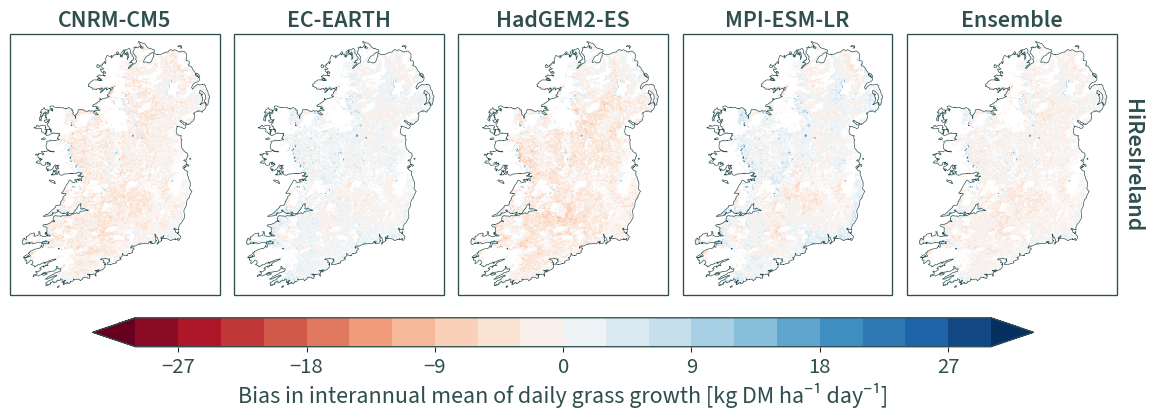

In [60]:
plot_bias(bias_abs_hr_mean_ens["gro"], label="Bias in interannual mean of daily grass growth [kg DM ha⁻¹ day⁻¹]", levels=np.arange(-30, 30 + 3, 3))

In [61]:
plot_bias(bias_rel_hr_mean_ens["gro"], label="Bias in interannual mean of daily grass growth [%]", levels=np.arange(-100, 100 + 10, 10))

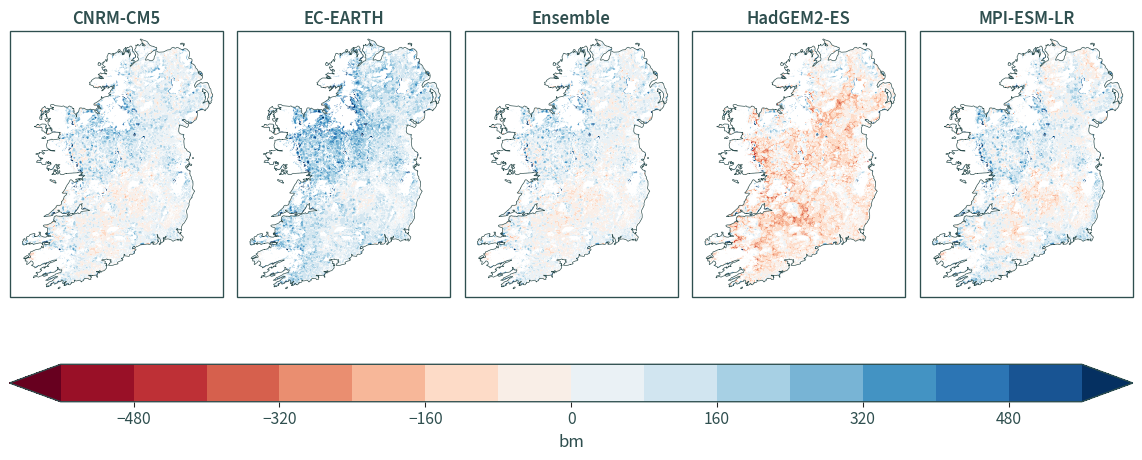

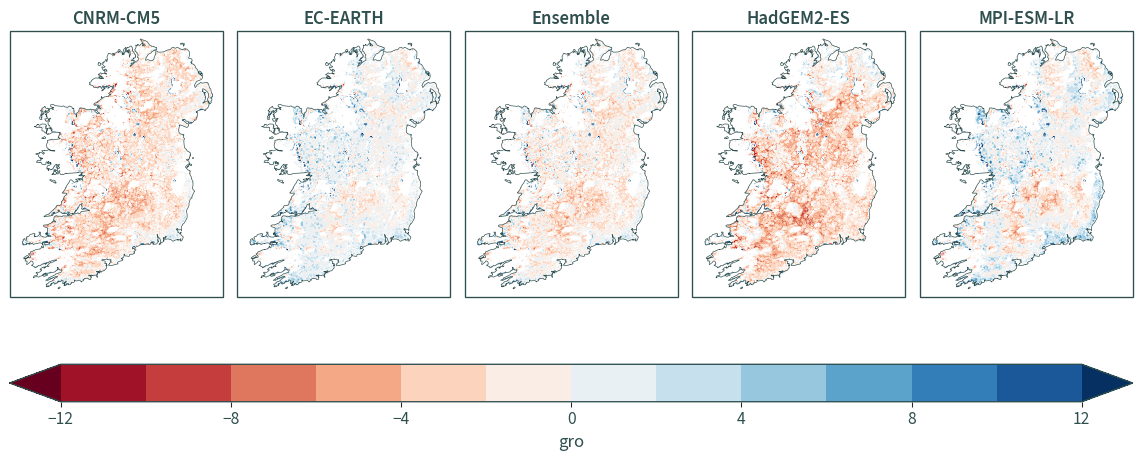

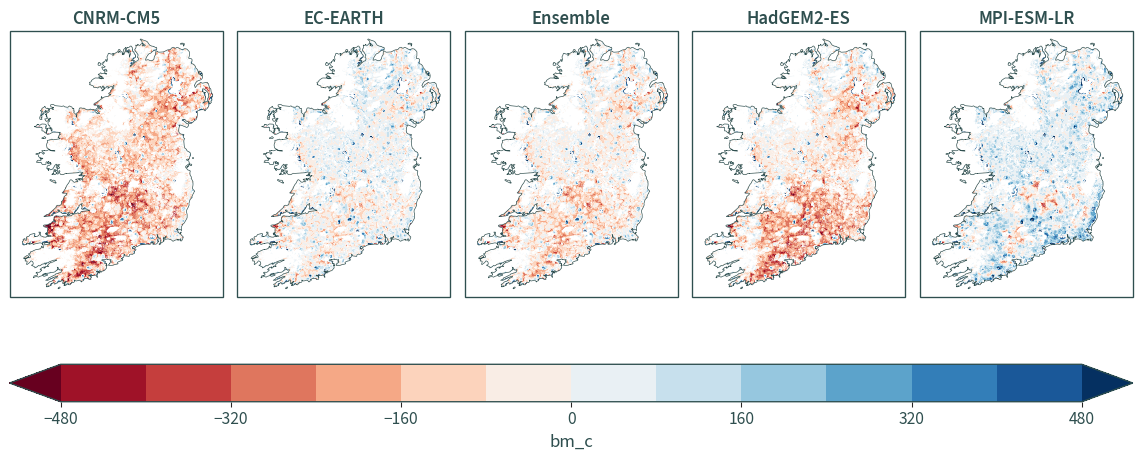

In [9]:
for v in bias_abs_hr_mean_ens.data_vars:
    plot_bias(bias_abs_hr_mean_ens, v)

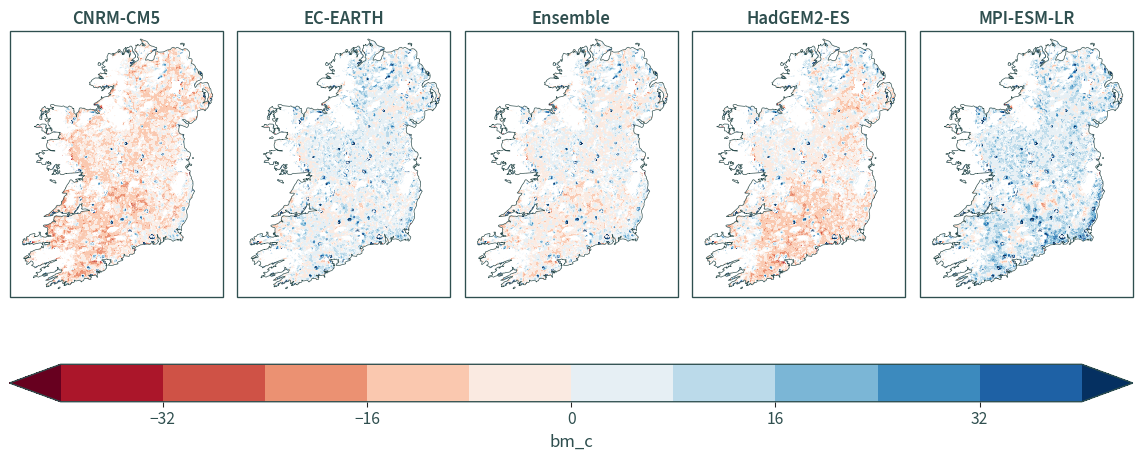

In [10]:
for v in bias_rel_hr_mean_ens.data_vars:
    plot_bias(bias_rel_hr_mean_ens, v)